# Linear Regression on Boston Housing Data Set

There isn't much commentary on this notebook. If you want to see my logic with this implementation, go to michelliao.com

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Visualizing the Dataset

In [90]:
df_train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [92]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/Users/michelliao/miniforge3/envs/kaggle/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

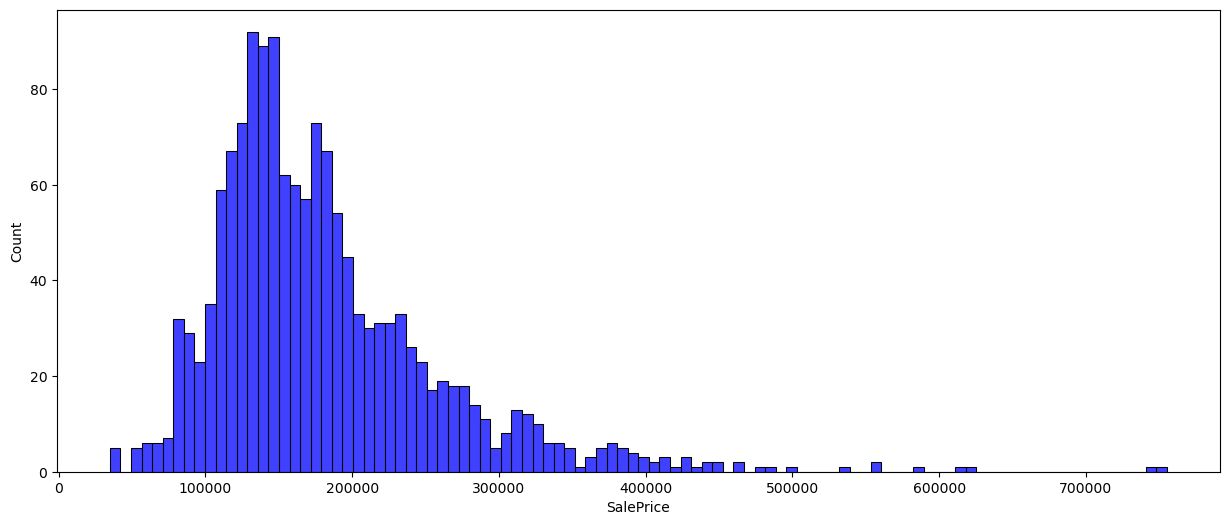

In [93]:
plt.figure(figsize=(15,6))
sns.histplot(df_train['SalePrice'], color='b', bins=100)

### Feature Scaling

In [94]:
# Create feature scaling function
def mean_normalization(arr):
    normalized_arr = (arr - np.mean(arr)) / np.ptp(arr)
    return normalized_arr

def mean_normalization_y(arr):
    max_y = np.max(arr)
    min_y = np.min(arr)
    avg = np.mean(arr)

    normalized_arr = (arr - avg) / (max_y - min_y)
    return normalized_arr, max_y, min_y, avg

# Arbitrarily choosing these features
xFullBath = df_train['FullBath'].to_numpy()
xLotArea = df_train['LotArea'].to_numpy()
xYearBuilt = df_train['YearBuilt'].to_numpy()

xFullBath = mean_normalization(xFullBath)
xLotArea = mean_normalization(xLotArea)
xYearBuilt = mean_normalization(xYearBuilt)

print(f'First 5 terms of FullBath: {xFullBath[:5]}')
print(f'First 5 terms of LotArea: {xLotArea[:5]}')
print(f'First 5 terms of YearBuilt: {xYearBuilt[:5]}')

First 5 terms of FullBath: [ 0.14497717  0.14497717  0.14497717 -0.18835616  0.14497717]
First 5 terms of LotArea: [-0.00966056 -0.00428534  0.00342692 -0.00451905  0.01749595]
First 5 terms of YearBuilt: [ 0.22994342  0.03429124  0.21545067 -0.40773774  0.20820429]


In [95]:
# Create input matrix, m examples by n features
X = np.vstack((xFullBath, xLotArea, xYearBuilt)).transpose()
print(f'X is:\n {X}\n')
print(f'Shape of X is: {X.shape}\n')

y = df_train['SalePrice'].to_numpy()
y, max_y, min_y, avg = mean_normalization_y(y)
print(f'y is: {y}')

X is:
 [[ 0.14497717 -0.00966056  0.22994342]
 [ 0.14497717 -0.00428534  0.03429124]
 [ 0.14497717  0.00342692  0.21545067]
 ...
 [ 0.14497717 -0.00689349 -0.21933194]
 [-0.18835616 -0.00373848 -0.15411455]
 [-0.18835616 -0.00271017 -0.0454189 ]]

Shape of X is: (1460, 3)

y is: [ 0.03829858  0.00080378  0.05912902 ...  0.11884294 -0.05387612
 -0.04641188]


### Implementing Linear Regression

In [96]:
class LinearRegression:
    def __init__(self):
        self.weights = None
        self.bias = None
    
    def gradient_descent(self, X, y, epochs, learning_rate=0.01):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0.0

        epochCosts = []

        for i in range(epochs):
            # Find predicted values
            f_wb = np.matmul(X, self.weights) + self.bias

            # Calculate cost
            err = f_wb - y
            cost = np.sum(err**2) / (2 * m)
            epochCosts.append(cost)
            if i % 50 == 0:
                print(f'The cost at epoch {i} is: {cost}')

            dJ_dw = np.matmul(X.T, err) / m
            dJ_db = np.sum(err) / m

            self.weights -= learning_rate * dJ_dw
            self.bias -= learning_rate * dJ_db

        return self.weights, self.bias, epochCosts # return weights, bias, costs for graphing
    
    def predict(self, X):
        return np.matmul(X, self.weights) + self.bias


The cost at epoch 0 is: 0.00608124716873048
The cost at epoch 50 is: 0.005454268157092759
The cost at epoch 100 is: 0.004989486212625797
The cost at epoch 150 is: 0.004644466770844296
The cost at epoch 200 is: 0.004387909322194597
The cost at epoch 250 is: 0.004196723019506526
The cost at epoch 300 is: 0.004053870681941074
The cost at epoch 350 is: 0.0039467792668504455
The cost at epoch 400 is: 0.003866167949089527
The cost at epoch 450 is: 0.0038051840685157197
The cost at epoch 500 is: 0.003758766046130464
The cost at epoch 550 is: 0.003723173629662313
The cost at epoch 600 is: 0.0036956415023259815
The cost at epoch 650 is: 0.0036741238424572997
The cost at epoch 700 is: 0.003657105939235996
The cost at epoch 750 is: 0.0036434652487820182
The cost at epoch 800 is: 0.003632368903832644
The cost at epoch 850 is: 0.0036231981026535196
The cost at epoch 900 is: 0.003615492318507617
The cost at epoch 950 is: 0.0036089081255812495
The cost at epoch 1000 is: 0.0036031888044855817
The cost

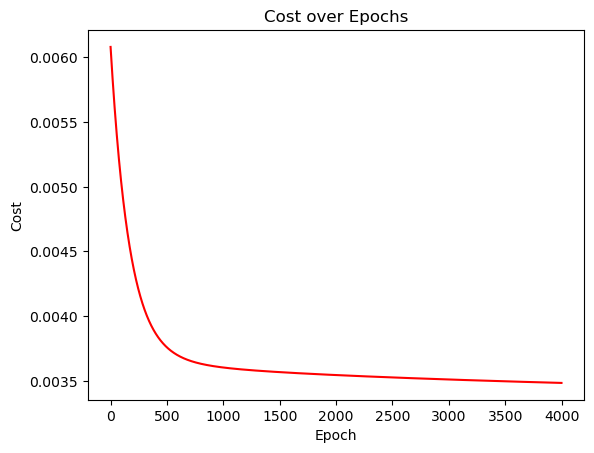

In [97]:
model = LinearRegression()

weights, bias, epochCosts = model.gradient_descent(X, y, 4000, 0.05)

xPlot = np.arange(0, len(epochCosts))

fig, ax = plt.subplots()
ax.plot(xPlot, epochCosts, 'r-')
ax.set(title='Cost over Epochs', xlabel='Epoch', ylabel='Cost')
plt.show()

In [98]:
df_test = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
df_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


### Predicting Housing Prices

In [99]:

FullBath = df_test['FullBath'].to_numpy()
LotArea = df_test['LotArea'].to_numpy()
YearBuilt = df_test['YearBuilt'].to_numpy()

FullBath = mean_normalization(FullBath)
LotArea = mean_normalization(LotArea)
YearBuilt = mean_normalization(YearBuilt)

X_test = np.vstack((FullBath, LotArea, YearBuilt)).transpose()

predictions = model.predict(X_test)
# Convert predictions to dollar values
predictions = predictions * (max_y - min_y) + avg
print(predictions)

[151181.19230301 154559.36703961 232570.27945335 ... 169852.13759891
 177478.04136154 218983.51746857]


### Testing the Model Against PyTorch

In [100]:
import torch
import torch.nn as nn

In [101]:
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

input_size = X.shape[1] # Number of features
output_size = 1 # One value, the price of the house

model = nn.Linear(input_size, output_size)

criterion = nn.MSELoss() # Defines the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


# Training
epochs = 4000
for epoch in range(epochs):
    y_hat = model(X_torch)
    loss = criterion(y_hat, y_torch)

    loss.backward() # Backprop

    optimizer.step() # Updates weights
    optimizer.zero_grad()

    if epoch % 50 == 0:
        print(f'The cost at epoch {epoch} is: {loss.item():.4f}')

The cost at epoch 0 is: 0.0277


The cost at epoch 50 is: 0.0122
The cost at epoch 100 is: 0.0122
The cost at epoch 150 is: 0.0122


/Users/michelliao/miniforge3/envs/kaggle/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1460])) that is different to the input size (torch.Size([1460, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


The cost at epoch 200 is: 0.0122
The cost at epoch 250 is: 0.0122
The cost at epoch 300 is: 0.0122
The cost at epoch 350 is: 0.0122
The cost at epoch 400 is: 0.0122
The cost at epoch 450 is: 0.0122
The cost at epoch 500 is: 0.0122
The cost at epoch 550 is: 0.0122
The cost at epoch 600 is: 0.0122
The cost at epoch 650 is: 0.0122
The cost at epoch 700 is: 0.0122
The cost at epoch 750 is: 0.0122
The cost at epoch 800 is: 0.0122
The cost at epoch 850 is: 0.0122
The cost at epoch 900 is: 0.0122
The cost at epoch 950 is: 0.0122
The cost at epoch 1000 is: 0.0122
The cost at epoch 1050 is: 0.0122
The cost at epoch 1100 is: 0.0122
The cost at epoch 1150 is: 0.0122
The cost at epoch 1200 is: 0.0122
The cost at epoch 1250 is: 0.0122
The cost at epoch 1300 is: 0.0122
The cost at epoch 1350 is: 0.0122
The cost at epoch 1400 is: 0.0122
The cost at epoch 1450 is: 0.0122
The cost at epoch 1500 is: 0.0122
The cost at epoch 1550 is: 0.0122
The cost at epoch 1600 is: 0.0122
The cost at epoch 1650 is: 0.0

In [102]:
# Predict new house prices
X_test_tensor = torch.from_numpy(X_test.copy()).float()

predictions_tensor = model(X_test_tensor)

predictions_torch = predictions_tensor.detach().numpy()
# Convert predictions to dollar values
predictions_torch = predictions_torch * (max_y - min_y) + avg

print(f'PyTorch Predictions: {predictions_torch}\n Our Predictions: {predictions}')

PyTorch Predictions: [[180921.18039281]
 [180921.18051349]
 [180921.18295011]
 ...
 [180921.18098093]
 [180921.18105704]
 [180921.18254608]]
 Our Predictions: [151181.19230301 154559.36703961 232570.27945335 ... 169852.13759891
 177478.04136154 218983.51746857]
